# Unstable photon orbit

In this example notebook, we want to study geodesics in the ``null`` case around a Schwarzschild black hole, to show the capability of PyGRO to correctly reproduce known results from textbooks.

Let's start by importing the necessary modules:

In [1]:
import pygro
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['text.usetex'] = False
mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.color'] = "#cdcdcd"
mpl.rcParams['grid.linestyle'] = ":"
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["#767afe", "#2b926c", "#b53546", "#e78b50", "#703676", "#b68ec4", "#37b4b4", "#c8c330"]) 
mpl.rcParams['font.family'] = 'cmr10'
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['axes.formatter.use_mathtext'] = True
mpl.rcParams['axes.unicode_minus']=False

defining the usual Schwarzschild metric:

In [3]:
name = "Schwarzschild spacetime"
coordinates = ["t", "r", "theta", "phi"]

transform_functions = [
    "t",
    "r*sin(theta)*cos(phi)",
    "r*sin(theta)*sin(phi)",
    "r*cos(theta)"
]

line_element = "-(1-2*M/r)*dt**2+1/(1-2*M/r)*dr**2+r**2*(dtheta**2+sin(theta)**2*dphi**2)"

metric = pygro.Metric(
    name = name,
    coordinates = coordinates,
    line_element = line_element,
    transform = transform_functions,
    M = 1,
)


(PyGRO) INFO: Initializing Schwarzschild spacetime.
(PyGRO) INFO: Calculating inverse metric.
(PyGRO) INFO: Calculating symbolic equations of motion.
(PyGRO) INFO: Computing helper functions to normalize 4-velocity.
(PyGRO) INFO: The Metric (Schwarzschild spacetime) has been initialized.


and defining the ``GeodesicEngine`` with a stopping criterion at the event horizon:

In [4]:
geo_engine = pygro.GeodesicEngine(metric)
geo_engine.set_stopping_criterion("r > 2.00001*M", "horizon")

(PyGRO) INFO: Linking Schwarzschild spacetime to the Geodesic Engine
(PyGRO) INFO: Metric linking complete.


We want to verify the general relativistic prediciton that there exist circular photon orbit. 

These correspond to strong lensing configurations in which the photon path is so bent that it circles around the black hole indefinitely.

In particular, around a Schwarzschild black hole, this can occurr only with orbits that have a radial coordinate $r_\textrm{UPO}=3M$, corresponding to an **unstable photon orbit**. Photons with $r<r_\textrm{UPO}$ will fall in the black hole, orbits with $r>r_\textrm{UPO}$ will escape to infinity.

Let's test this result.

This is particularly simple if we definte an ``Observer``, defined exaxtly as in the [Define a space-time Observer](https://rdellamonica.github.io/pygro/define_observer.html) tutorial.

In that case, the $\vec{f}_2$ vector of the observer's frame is directed along the vector $\vec{e}_\phi$ of the coordinate basis, *i.e.* perpendicularly with respect to the radial direction. We can thus move the observer around, changing its position from very close to the horizon (*e.g.* at $r_0=2.1M$) going otward (*e.g.* up to $r_0=6M$) and a fire several photons along the $\vec{f}_2$ direction.

We can do this by using the ``Observer.from_f2()`` method, assigning zero angles because we want to fire the photon perpendicularly to the radius, and integrate it for a given interval of proper time:

In [5]:
# Let's define an array of radii. 
r_arr = np.linspace(2.1, 6, 40)         # [2.1, 2.2, 2.3, ..., 5.7, 5.8, 5.9, 6.0]
 
geo_arr = []

# Initially we define the observer at the horizon (r = 2)
observer = pygro.Observer(
    metric,
    [0, 2, np.pi/2, 0],
    coframe = [
        "sqrt(1-2*M/r)*dt",
        "-dr/sqrt(1-2*M/r)",
        "-r*sin(theta)*dphi", 
        "-r*dtheta"
    ]
)

for r in r_arr:
    
    # We then loop over the different radii and change the position of the observer accordingly
    observer.x = [0, r, np.pi/2, 0]
    
    geo = pygro.Geodesic("null", geo_engine, verbose = False)
    geo.initial_x = observer.x
    geo.initial_u = observer.from_f2(0, 0, type = geo.type)
    
    geo_engine.integrate(geo, 100, 0.0001, verbose = False, accuracy_goal = 16, precision_goal = 16, hmax = 0.001 if r == 3 else 100, direction = "bw") 

    geo_arr.append(geo)

Note that we have set a smaller ``hamx`` for the case $r=3M$ because we know that this is supposed an unstable photon orbit and we thus want to the numerical precision to be under much stricter control in this case.

Let's visualize all the photon orbits that we have integrated:

(PyGRO) WARNING: Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


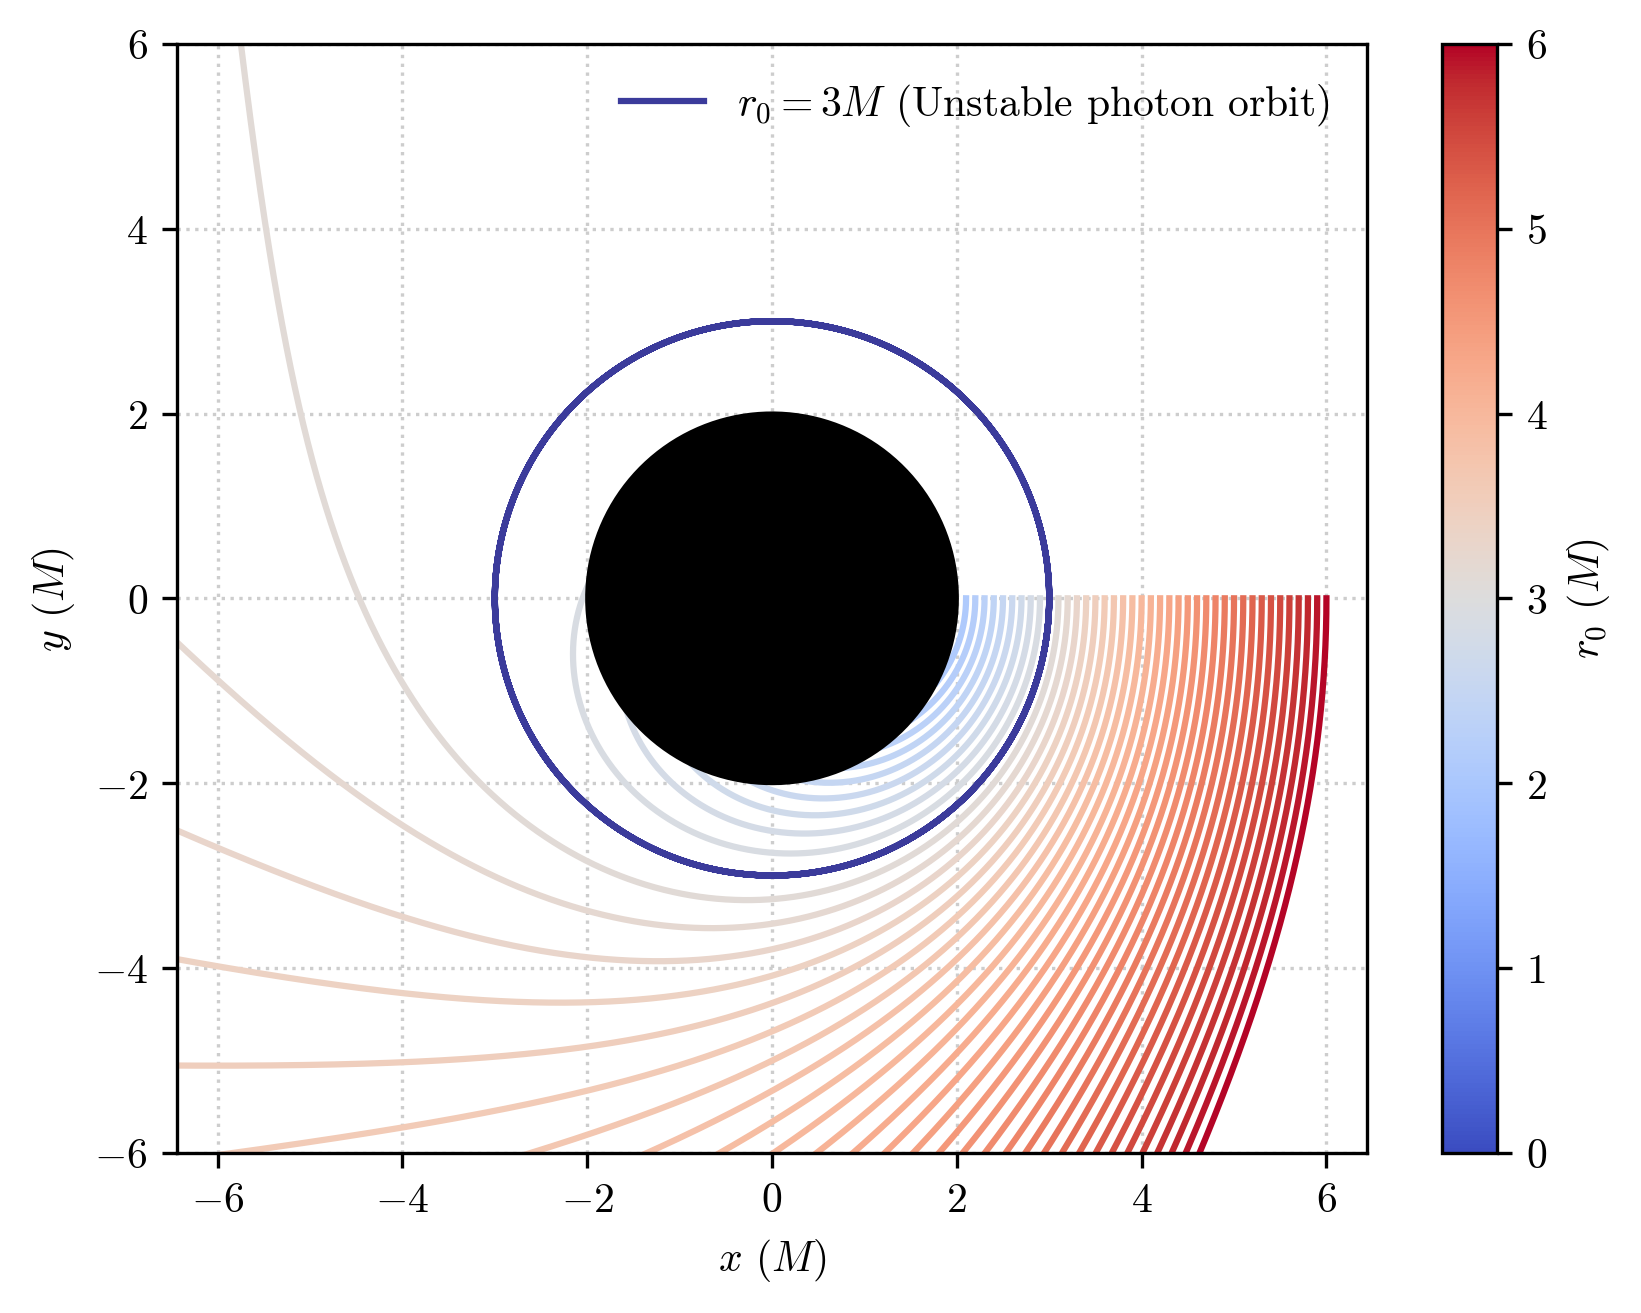

In [6]:
fig, ax = plt.subplots()


cmap = plt.get_cmap('coolwarm')
norm = mpl.colors.Normalize(vmin=0, vmax=6)
mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

for geo in geo_arr:
    t, x, y, z = metric.transform(geo.x.T)
    
    ax.plot(
        x, y,
        color = mappable.to_rgba(geo.initial_x[1]) if geo.initial_x[1] != 3 else "#3b3b9b",
        label = r"$r_0 = 3M$ (Unstable photon orbit)" if geo.initial_x[1] == 3 else None
    )

ax.axis('equal')

theta = np.linspace(0, 2*np.pi, 150)
x_bh = 2*np.cos(theta)
y_bh = 2*np.sin(theta)

ax.fill(x_bh, y_bh, color = "k", zorder = 100)

lim = 6

ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)

ax.set_axisbelow(True)

ax.set_xlabel('$x$ ($M$)')
ax.set_ylabel('$y$ ($M$)')

ax.legend()

fig.colorbar(mappable, ax = ax, label = r"$r_0$ ($M$)")
plt.show()

Gotcha!

We have plunging orbits for the cases with $r_0<r_\textrm{UPO}$, escaping orbits for $r_0>r_\textrm{UPO}$ and a perfectly circular orbit in the $r_0=r_\textrm{UPO}$ case.

We can also see this better by plotting for this specific case (which corresponds to the 10th geodesic in our array) the radial coordinate as a funciton of the affine parameter on the geodesic:

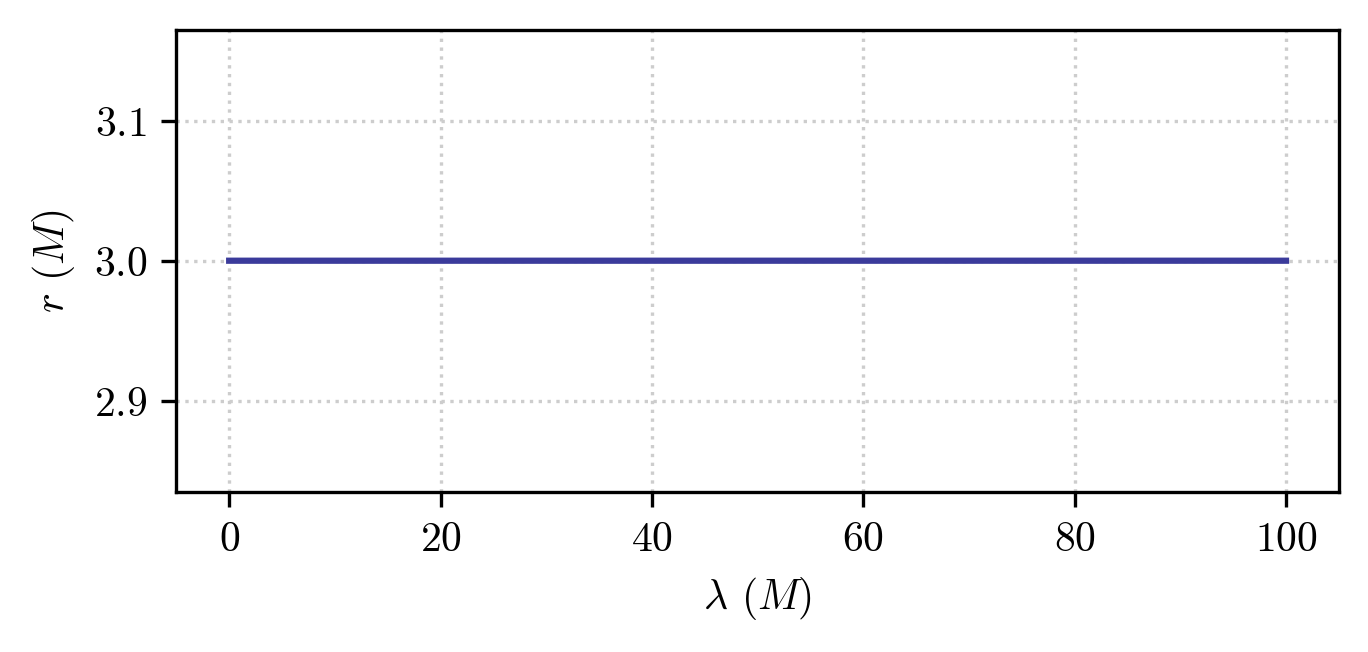

In [7]:
fig, ax = plt.subplots(figsize = (5,2))

ax.plot(geo_arr[9].tau, geo_arr[9].x[:,1], color  = "#3b3b9b")

ax.set_xlabel(r"$\lambda$ ($M$)")
ax.set_ylabel(r"$r$ ($M$)")

plt.show()

From which we see that the orbital radius is perfectly constant.